In [1]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Glob
using DelimitedFiles

rng = MersenneTwister(1337);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10418347893087869408\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-18201312794641862317\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10418347893087869408\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### TODO (WZ):
- For each simulation condition (clustered, spanning and individual) at steady state (time-step 150,000) compute changes in Wasserstein distance after randomly removing points (similar to code below). Consider separately Wasserstein distance for $H_0$ and $H_0 + H_1$. Each simulation (in `simulation-data` directory) consists of 200 cells. Change y axis to 4.0 and label with t = blah and delete the old stuff and put legends in top left and extend graph take off the abstract leave 3 bullet move TDA stuff up and leave room for persistence images( make it in python roughly like the other) In middle drop in wasserstein graphs right hand with experimental stuff.

In [2]:
#create function to take create dictionary to data for each condition type
function getdata(condition)
    filelist = glob("Pos_*.dat",string("simulation-data/", condition));
    filetodata = Dict{String, Array{Float64,2}}();
    sz = size(filelist)[1];
    for i in 1:sz
        filenamewext = split(filelist[i], '/')[3];
        filename = split(filenamewext, '.')[1];
        filenum = parse(Int, split(filename, '_')[2]);
        posarray = readdlm(filelist[i], ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            posarray[j] = chop(posarray[j]);
            xsign = 1;
            x_y = split(posarray[j], '-');
            if(x_y[1] == "")
                xsign = -1;
                x_y = deleteat!(x_y,1);
            end
            x_plus_y = [];
            if(size(x_y)[1] == 1)
                x_plus_y = split(posarray[j], '+');
                x_plus_y = map(a->parse(Float64,a),x_plus_y);
                push!(posx, x_plus_y[1]);
                push!(posy, x_plus_y[2]);
            else
                x_y = map(a->parse(Float64,a),x_y);
                x_y[1] *= xsign;
                x_y[2] *= -1;
                push!(posx,x_y[1]);
                push!(posy,x_y[2]);
            end
        end
        positions = transpose(hcat(posx, posy));    
        push!(filetodata, filename => positions)
    end
    return filetodata;
end


getdata (generic function with 1 method)

In [3]:
function wassersteinremoval(condition, filename, maxdimension,num_removals,num_reps, dictdata = nothing)
    conditiondict = Dict{String, Array{Float64,2}}();
    if(dictdata == nothing)
        conditiondict = getdata(condition);
    else
        conditiondict = dictdata;
    end
    pers_diag = eirene(conditiondict[filename], model="pc", maxdim=maxdimension)
    barcodedata = barcode(pers_diag)
    barcode_coord_vals = sort(unique(collect(Iterators.flatten(barcodedata))))
    max_coord = maximum(barcode_coord_vals)

    # if max value is Inf, normalize by second largest values
    if max_coord == Inf
        max_coord = barcode_coord_vals[end-1]
    end

    @assert max_coord != Inf

    # replace Inf values
    replace!(barcodedata, Inf=>max_coord)
    num_particles = size(conditiondict[filename])[2]
    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);

    for i in 1:num_removals
        for j in 1:num_reps
            permutation = randperm(rng, num_particles)
            keep_idx = permutation[1:(num_particles-i)]
            finalpos = conditiondict[filename];
            pos_tmp = finalpos[:,keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, barcodedata, q=2, p=2)
        end
    end
    return wasserstein_distances
end

wassersteinremoval (generic function with 2 methods)

In [4]:
function gettotalwasserstein(condition,dimension, num_removal, num_repetition)
    data = getdata(condition);
    wasserstein_all_time = Dict{String, Array{Float64,2}}();
    for (key,value) in data;
        wasserstein_distances = wassersteinremoval(condition,key,dimension,num_removal, num_repetition, data);
        push!(wasserstein_all_time, key=>wasserstein_distances);
    end
    return wasserstein_all_time
end



gettotalwasserstein (generic function with 1 method)

In [23]:
function plotwasserstein(condition, dimension, num_removal, num_repetition)
    data = getdata(condition);
    wassersteins = gettotalwasserstein(condition, dimension, num_removal, num_repetition)
    figure(figsize=(8,4))
    for (key,value) in wassersteins
        mean_ws_dist = mean(value, dims=2);
        std_ws_dist = std(value, dims=2);
        xs = convert(Array, 1:num_removal)
        lb = collect(Iterators.flatten(convert(Array,mean_ws_dist-std_ws_dist)))
        ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))

        
        plot(1:num_removal, mean_ws_dist, label=string("t = ",split(key,"_")[end][1:2],", n = ",size(data[key])[2]))
        ax = gca()
        fill_between(xs, lb, ub, alpha=0.2)
        
    end
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
    ylim(0,4)
    title(string(uppercase(condition[1]),split(condition[2:end],"_")[1:end]," Data and Wasserstein and Removals"))
    legend();
end

plotwasserstein (generic function with 1 method)

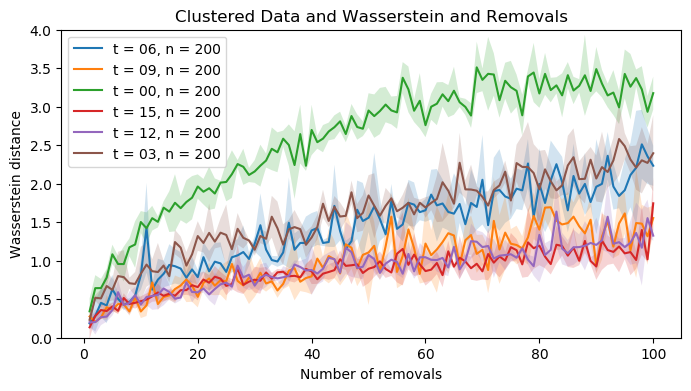

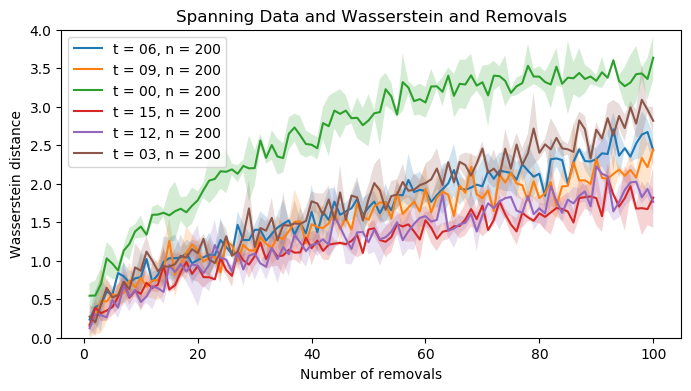

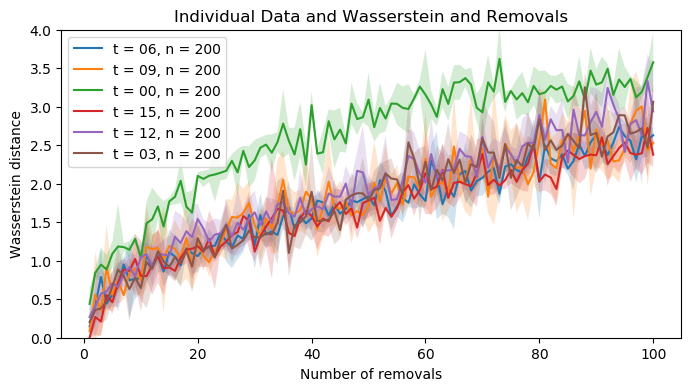

PyObject <matplotlib.legend.Legend object at 0x0000000040FEC438>

In [6]:
plotwasserstein("clustered",1, 100,3)
plotwasserstein("spanning",1,100,3)
plotwasserstein("individual",1,100,3)

In [7]:
function plottogether(timestep, dim, num_removal,num_repetition, conditions)
    figure(figsize=(8,4))
    for conditionstring in conditions
        data = getdata(conditionstring)
        lastwass = wassersteinremoval(conditionstring, timestep, dim,num_removal,num_repetition)
        mean_ws_dist = mean(lastwass, dims=2);
        std_ws_dist = std(lastwass, dims=2);
        xs = convert(Array, 1:num_removal)
        lb = collect(Iterators.flatten(convert(Array,mean_ws_dist-std_ws_dist)))
        ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))


        plot(1:100, mean_ws_dist, label=string(string(uppercase(conditionstring[1]),split(condition[2:end],"_")[1:end]),", t = ",split(timestep,"_")[end][1:2],", n = ",size(data[timestep])[2]))
        ax = gca()
        fill_between(xs, lb, ub, alpha=0.2)
    end
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
    title(string("Time-step ",split(timestep,"_")[end][1:2] ," Data and Wasserstein and Removals"))
    ylim(0,4);
    legend();
end

plottogether (generic function with 1 method)

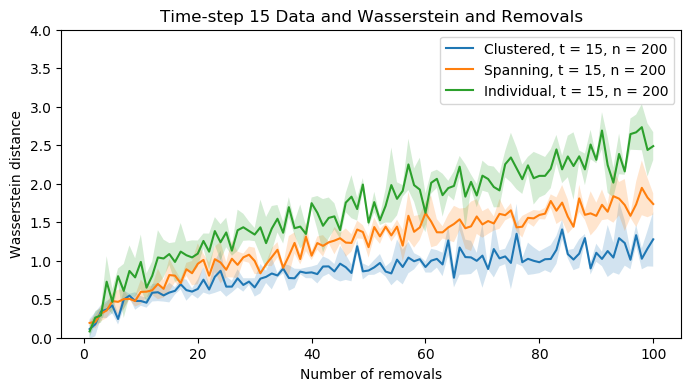

In [8]:
conditions = ["clustered", "spanning","individual"];
plottogether("Pos_150000", 1, 100, 3,conditions);

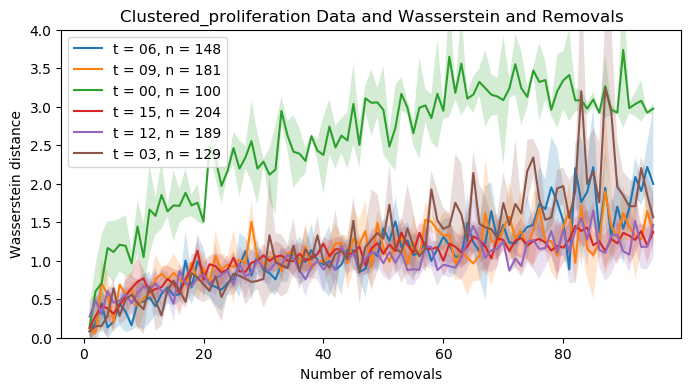

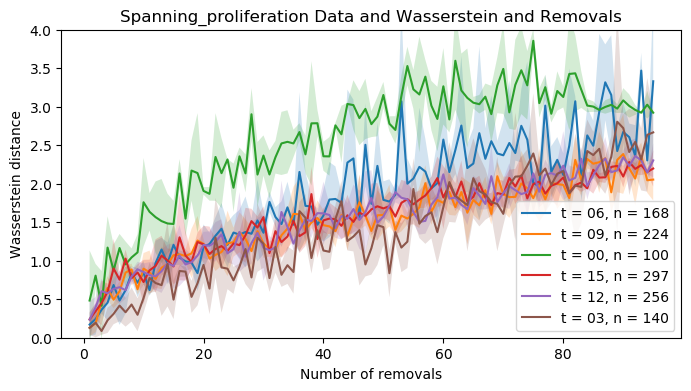

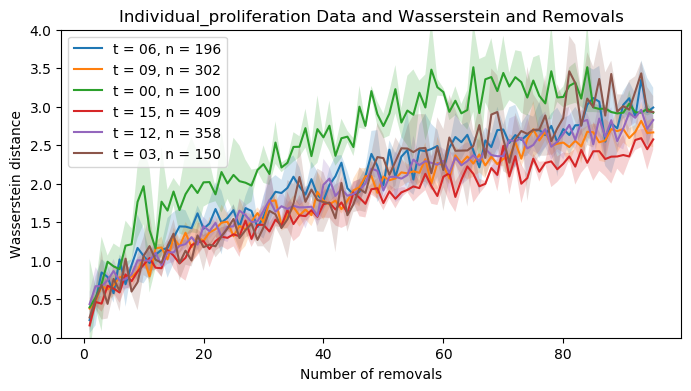

PyObject <matplotlib.legend.Legend object at 0x000000003076B128>

In [20]:
plotwasserstein("clustered_proliferation",1, 95,3)
plotwasserstein("spanning_proliferation",1,95,3)
plotwasserstein("individual_proliferation",1,95,3)

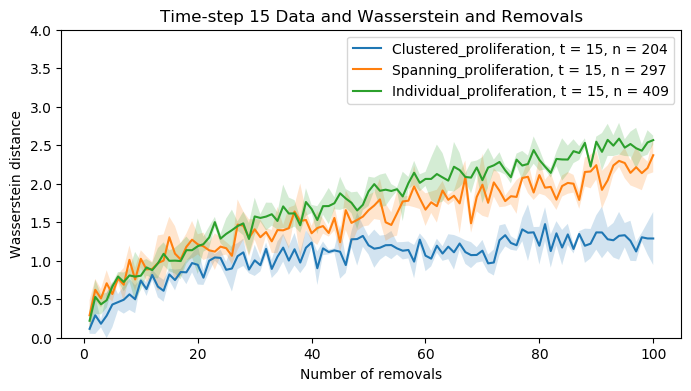

In [21]:
conditions = ["clustered_proliferation", "spanning_proliferation","individual_proliferation"];
plottogether("Pos_150000", 1, 100, 3,conditions);